In [1]:
# all imports
#from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from matplotlib import cm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.linalg import solve

In [2]:
# create test data
# points P
P = [(1,1), (1,-1), (-1,1), (-1,-1), (0,0), (1,0), (-1,0), (0,1), (0,-1)]
# test z values
f1 = [1.0, -0.5, 1.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0]
f2 = [1.0, -1.0, 0.0, 0.0, 1.0, 0.0, -1.0, -1.0, 1.0]

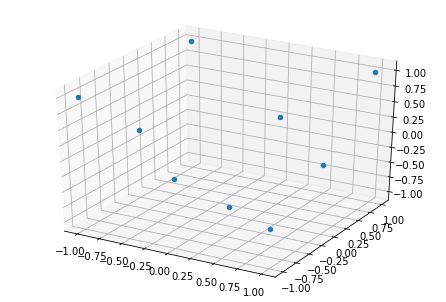

In [3]:
#x = np.array([p[0] for p in P])
#y = np.array([p[1] for p in P])
x, y = zip(*P)
z = f1

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x,y,z, depthshade=False)
#plt.savefig('test.pdf')
plt.show()

---
# Ordinary Least Squares Surface Fitting

In [4]:
def B(x,y):
    return np.array([1,x,y,x*x,x*y,y*y])

def BBT(b):
    return b*b[:,None]


In [5]:
# points P
P = [(1,1), (1,-1), (-1,1), (-1,-1), (0,0), (1,0), (-1,0), (0,1), (0,-1)]
# test z values
f1 = [1.0, -0.5, 1.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0]

f = np.zeros(6)
bbt = np.zeros((6,6))

for i in range(len(P)):
    b = B(P[i][0],P[i][1])
    bbt += BBT(b)
    f += b * f2[i]

c = np.linalg.lstsq(bbt,f,rcond=None)[0]


In [6]:
def f(x_,y_): # returns z value
    b = B(x_,y_)
    return np.dot(b,c)


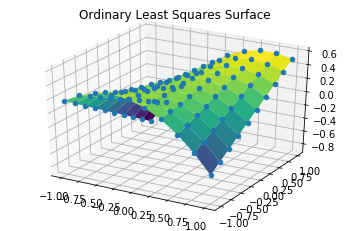

In [7]:
# draw function on grid
numpoints = 10

xs = ys = np.linspace(-1, 1, numpoints)
xs,ys = np.meshgrid(xs,ys)
zs = f(xs,ys)


fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(xs, ys, zs,cmap='viridis', edgecolor='none')
ax.scatter(xs,ys,zs, depthshade=False)
ax.set_title('Ordinary Least Squares Surface')
plt.show()

---
# Weighted Least Squares Surface Fitting

In [8]:
def dist2d(p1,p2): # 2d points
    dx = np.power(p1[0] - p2[0], 2)
    dy = np.power(p1[1] - p2[1], 2)
    return np.sqrt(dx + dy)

def phi(d, radius): # Wendland weight
    return np.power(1 - d/radius, 4) * (4 * d/radius + 1)

def plotPhi(radius):
    x = np.linspace(0,radius,20)
    y = [phi(d,radius) for d in x]
    plt.plot(x,y)
    plt.show()
    
#plotPhi(7)

In [9]:
def fwls(x,y,c): # returns z value (WLS)
    b = B(x,y)
    return np.dot(b,c)

def getInRadius(p,radius,PC): # specific gridpoint p and radius to search in and Point Cloud PC
    points = []
    weights = []
    for i in range(len(PC)):
        d = dist2d(p,PC[i])
        if d < radius and d > 0:
            points += [PC[i]]
            weights += [phi(d,radius)]
    return points, weights

def makeGrid(startXY, endXY, numberOfCells, radius, pointCloud, plot = True):
    s = np.linspace(startXY, endXY, numberOfCells)
    gridpoints = [(i,j) for i in s for j in s]
    cx = [] # each gridpoints coefficients
    for p in gridpoints:
        points,weights = getInRadius(p,radius,pointCloud)
        wf = np.zeros(6)
        wbbt = np.zeros((6,6))
        for i in range(len(points)):
            b = B(points[i][0],points[i][1])
            wbbt += BBT(b) * weights[i]
            wf += b * f2[i] * weights[i]
        
        cx += [np.linalg.lstsq(wbbt,wf,rcond=None)[0]]
    #return [[gridpoints[i][0],gridpoints[i][1],fwls(gridpoints[i],cx[i])] for i in range(len(gridpoints))]
    z = [fwls(gridpoints[i][0],gridpoints[i][1],cx[i]) for i in range(len(gridpoints))]
    if plot:
        xx,yy = np.meshgrid(s,s)
        zz = np.reshape(z,(numberOfCells,numberOfCells))
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.plot_surface(xx, yy, zz,cmap='viridis', edgecolor='none')
        #ax.scatter(xx,yy,zz, depthshade=False)
        ax.set_title('Weighted Least Squares Surface')
        plt.show()
    return z

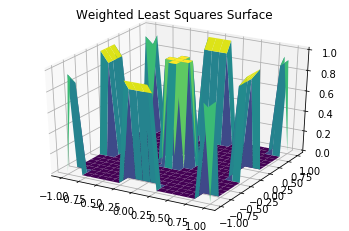

In [10]:
z = makeGrid(-1,1,20,0.2,P,True)